In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy

# Download once (run these once if not done already)
nltk.download('punkt')
nltk.download('stopwords')

# Define stop words and load spaCy model
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')  # You can install it using: python -m spacy download en_core_web_sm

[nltk_data] Downloading package punkt to /home/raheen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/raheen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = text.lower()                # Lowercase the text
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation/numbers
    tokens = word_tokenize(text)       # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    text = ' '.join(tokens)            # Join back to string
    doc = nlp(text)                    # spaCy processing
    lemmatized_tokens = [token.lemma_ for token in doc]  # Lemmatize
    return ' '.join(lemmatized_tokens)


In [9]:
import pandas as pd
# Load job descriptions and resumes


df_jobs = pd.read_csv('/home/raheen/NLP_Imp/Resume/training_data.csv')
df_resumes = pd.read_csv('/home/raheen/NLP_Imp/Resume/Resume.csv')

# Safe sampling (max available = 853 for jobs)
df_jobs = df_jobs.sample(n=min(1000, len(df_jobs)), random_state=42).reset_index(drop=True)
df_resumes = df_resumes.sample(n=min(1000, len(df_resumes)), random_state=42).reset_index(drop=True)

# Clean text columns
df_jobs['clean_jd'] = df_jobs['job_description'].astype(str).apply(preprocess_text)
df_resumes['clean_resume'] = df_resumes['Resume_str'].astype(str).apply(preprocess_text)

In [11]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # You can try others too


/home/raheen/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Encode resumes and job descriptions into embeddings
resume_embeddings = model.encode(df_resumes['clean_resume'].tolist(), show_progress_bar=True)
job_embeddings = model.encode(df_jobs['clean_jd'].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]/home/raheen/venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 27/27 [00:37<00:00,  1.40s/it]


In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Compute cosine similarity (resume x job matrix)
similarity_matrix = cosine_similarity(resume_embeddings, job_embeddings)

# Get top-5 matching job indices for each resume
top_k = 5
top_matches = np.argsort(-similarity_matrix, axis=1)[:, :top_k]  # descending sort

# Create a result DataFrame
results = []
for i, job_indices in enumerate(top_matches):
    for rank, job_idx in enumerate(job_indices):
        results.append({
            'resume_id': i,
            'job_id': job_idx,
            'similarity_score': similarity_matrix[i][job_idx],
            'rank': rank + 1,
            'resume_text': df_resumes['clean_resume'].iloc[i],
            'job_text': df_jobs['clean_jd'].iloc[job_idx]
        })

df_results = pd.DataFrame(results)


In [28]:
# Show selected columns for better readability
cols_to_show = ['resume_id', 'job_id', 'similarity_score', 'rank', 'resume_text', 'job_text']
print(df_results[cols_to_show].head(10))


   resume_id  job_id  similarity_score  rank  \
0          0     359          0.760581     1   
1          0      80          0.758557     2   
2          0     562          0.753826     3   
3          0      78          0.742811     4   
4          0     438          0.740512     5   
5          1     426          0.674761     1   
6          1     120          0.672863     2   
7          1     282          0.661366     3   
8          1     363          0.626453     4   
9          1      14          0.624106     5   

                                         resume_text  \
0  kpandipou koffi summary compassionate teaching...   
1  kpandipou koffi summary compassionate teaching...   
2  kpandipou koffi summary compassionate teaching...   
3  kpandipou koffi summary compassionate teaching...   
4  kpandipou koffi summary compassionate teaching...   
5  director digital transformation executive prof...   
6  director digital transformation executive prof...   
7  director digital tra

In [29]:
# Make a copy to avoid modifying the original
df_display = df_results.copy()

# Truncate long text fields for horizontal display
df_display['resume_text'] = df_display['resume_text'].str.slice(0, 80) + '...'
df_display['job_text'] = df_display['job_text'].str.slice(0, 80) + '...'

# Columns to show
cols_to_show = ['resume_id', 'job_id', 'similarity_score', 'rank', 'resume_text', 'job_text']

# Print top 10 results
print(df_display[cols_to_show].head(10).to_string(index=False))


 resume_id  job_id  similarity_score  rank                                                                         resume_text                                                                            job_text
         0     359          0.760581     1 kpandipou koffi summary compassionate teaching professional deliver exemplary su... requisition work type full time location campusmedical center schooldepartment n...
         0      80          0.758557     2 kpandipou koffi summary compassionate teaching professional deliver exemplary su... requisition i d job title executive coordinator office president department offi...
         0     562          0.753826     3 kpandipou koffi summary compassionate teaching professional deliver exemplary su... post june job type contract category information technology description client c...
         0      78          0.742811     4 kpandipou koffi summary compassionate teaching professional deliver exemplary su... job description get know alor

In [21]:
# ----- Custom Resume Text -----
custom_resume = """
Experienced software engineer with 5 years of experience in Python, machine learning,
and web development. Proven track record in delivering scalable AI solutions and
maintaining cloud infrastructure. Familiar with NLP, REST APIs, and agile methodology.
"""

# ----- Preprocess Custom Resume -----
cleaned_resume = preprocess_text(custom_resume)

# ----- Encode Resume Using SentenceTransformer -----
custom_embedding = model.encode([cleaned_resume])[0]  # single embedding

# ----- Compute Similarity with All Job Descriptions -----
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity([custom_embedding], job_embeddings)[0]

# ----- Get Top 5 Matches -----
top_indices = similarities.argsort()[-5:][::-1]

# ----- Build Results -----
results = []
for rank, idx in enumerate(top_indices, 1):
    results.append({
        'resume_id': 'custom',
        'job_id': idx,
        'similarity_score': similarities[idx],
        'rank': rank,
        'resume_text': custom_resume,
        'job_text': df_jobs['job_description'][idx]
    })

df_custom_results = pd.DataFrame(results)

# Optional: Truncate for display
df_custom_results['resume_text'] = df_custom_results['resume_text'].str.slice(0, 80) + '...'
df_custom_results['job_text'] = df_custom_results['job_text'].str.slice(0, 80) + '...'

# Display Top Matches
cols_to_show = ['resume_id', 'job_id', 'similarity_score', 'rank', 'resume_text', 'job_text']
print(df_custom_results[cols_to_show].to_string(index=False))


resume_id  job_id  similarity_score  rank                                                                          resume_text                                                                                job_text
   custom     740          0.576846     1 \nExperienced software engineer with 5 years of experience in Python, machine lea...   requirement\n\n bachelors degree in information systems software engineering compu...
   custom     795          0.553557     2 \nExperienced software engineer with 5 years of experience in Python, machine lea...      design develop and test high quality software features by understanding user ne...
   custom     441          0.512036     3 \nExperienced software engineer with 5 years of experience in Python, machine lea...   about us innovating to solve realworld problems\n\napplied insight enhances the ab...
   custom     609          0.510787     4 \nExperienced software engineer with 5 years of experience in Python, machine lea...  positions   

/home/raheen/venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


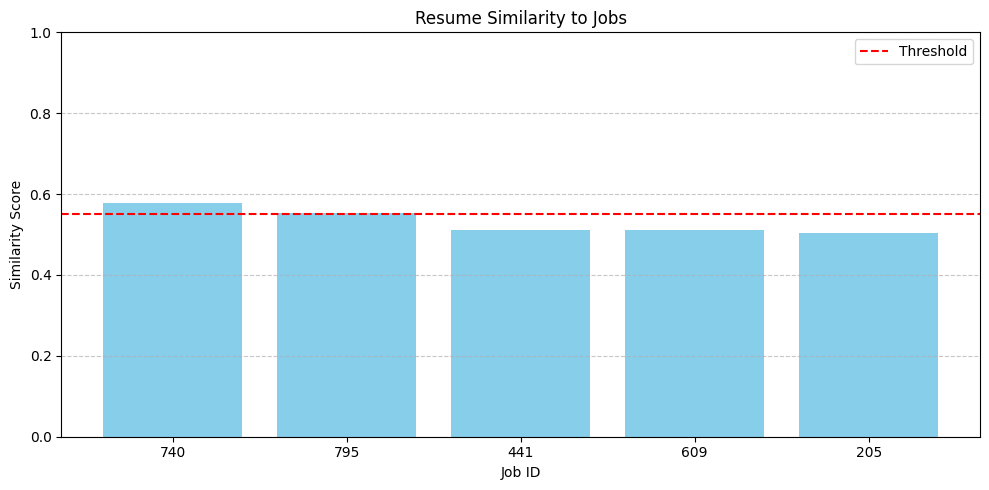

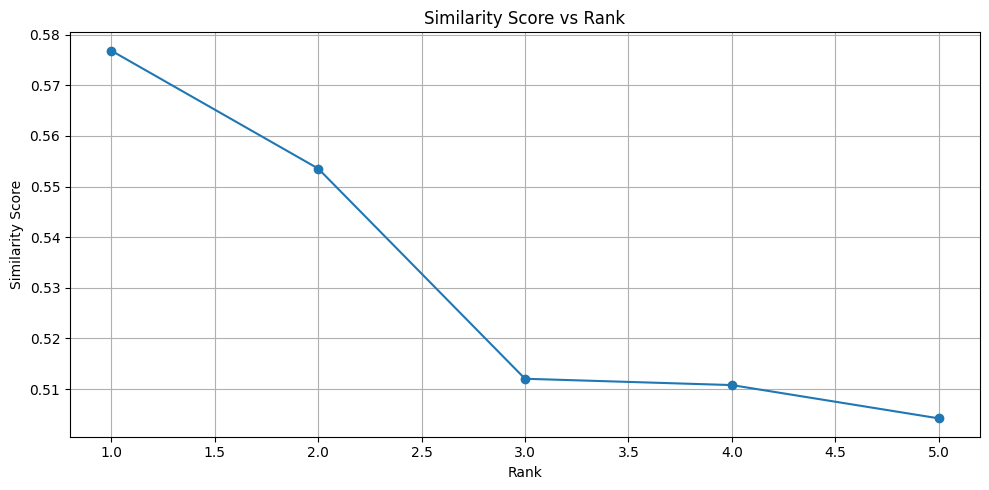

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {
    'job_id': [740, 795, 441, 609, 205],
    'similarity_score': [0.576846, 0.553557, 0.512036, 0.510787, 0.504214],
    'rank': [1, 2, 3, 4, 5]
}

df = pd.DataFrame(data)

# Bar chart: Similarity vs Job ID
plt.figure(figsize=(10, 5))
plt.bar(df['job_id'].astype(str), df['similarity_score'], color='skyblue')
plt.xlabel("Job ID")
plt.ylabel("Similarity Score")
plt.title("Resume Similarity to Jobs")
plt.ylim(0, 1)
plt.axhline(y=0.55, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Line plot: Rank vs Similarity
plt.figure(figsize=(10, 5))
plt.plot(df['rank'], df['similarity_score'], marker='o', linestyle='-')
plt.xlabel("Rank")
plt.ylabel("Similarity Score")
plt.title("Similarity Score vs Rank")
plt.grid(True)
plt.tight_layout()
plt.show()
